In [8]:
#5.11 high way
# last modified 2024/4/24 
# %matplotlib ipympl
%matplotlib inline
import h5py 
import glob
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from DasTools import DasPrep as dp
import os
import datetime
import matplotlib
import logging
import csv
import time
def concat(flist , start = 0 , span = 20 ):
    datalist = []

    for fname in flist[ start : min( start + span , len(flist) ) ]:
        data = dp.read_das(fname)
        datalist.append(data)

    
    data = np.concatenate(datalist, axis = 1)
    utc_datetime = datetime.datetime.strptime(flist[start][-22 : -7],'%Y%m%d_%H%M%S') + datetime.timedelta(hours=+8)
    utc_day = utc_datetime.strftime("%m-%d %H:%M")
    print("cat", data.shape)
    return data , utc_datetime, utc_day 


def psd(h5file , startn, endn  ,span_each_pic , dt , window ,ch_list ):
    with h5py.File(h5file, 'a') as f:
    # 创建一个dataset
        concat_time = 0
        # ch_list = [i for i in range(2176)]
        for n in range(startn, endn , span_each_pic):
            data , utc_datetime, utc_day = concat(flist , start= n ,span= span_each_pic)
            fs = 1/dt

            nfft = window*fs
            start = time.time()
            for i in range(len(ch_list)):
                ch = ch_list[i]
                if not f.__contains__(str(ch_list[i])):   #判断这个组存不存在
                    g = f.create_group(str(ch_list[i]))
                else:
                    g = f[str(ch_list[i])]
                # g =  f.create_group(str(ch_list[i]))  
                [f1,Pxx1] = signal.welch(data[i],                   # 随机信号
                                nfft=nfft,               # 每个窗的长度
                                fs=fs,                   # 采样频率   
                                # detrend='mean',          # 去掉均值
                                window=np.hanning(nfft), # 加汉尼窗
                                noverlap=int(nfft*3/4),  # 每个窗重叠75%的数据
                                )        # 求单边谱
                g.create_dataset(str(utc_day),  data=Pxx1, chunks = (3001) )
            concat_time +=  time.time() -start
            print(n , "拼接运行时间:%.2f min %d s"%( int(concat_time / 60) , concat_time%60) , datetime.datetime.now() , utc_day, "check in ")
        f.close()


#das数据
flist = glob.glob('/mnt/f/Highway_2024_0510/test03_05_10/*.h5')
flist.sort()
print(len(flist))
#psd存的位置
path = '/mnt/f/Highway_2024_0510/output/psd_6_6/'
if not os.path.exists(path):
    os.makedirs(path)
h5fname = path+ '/test03_05_10_1.hdf5'
#12个das文件拼接，90s的窗做psd
psd(h5fname , 0, len(flist) ,12 , dt= 0.001 , window=90, ch_list = [i for i in range(2176)] ) 




247
cat (2176, 360000)


KeyboardInterrupt: 

(2040, 3001)
(2040, 3001)
73.34113438883729 89863.38


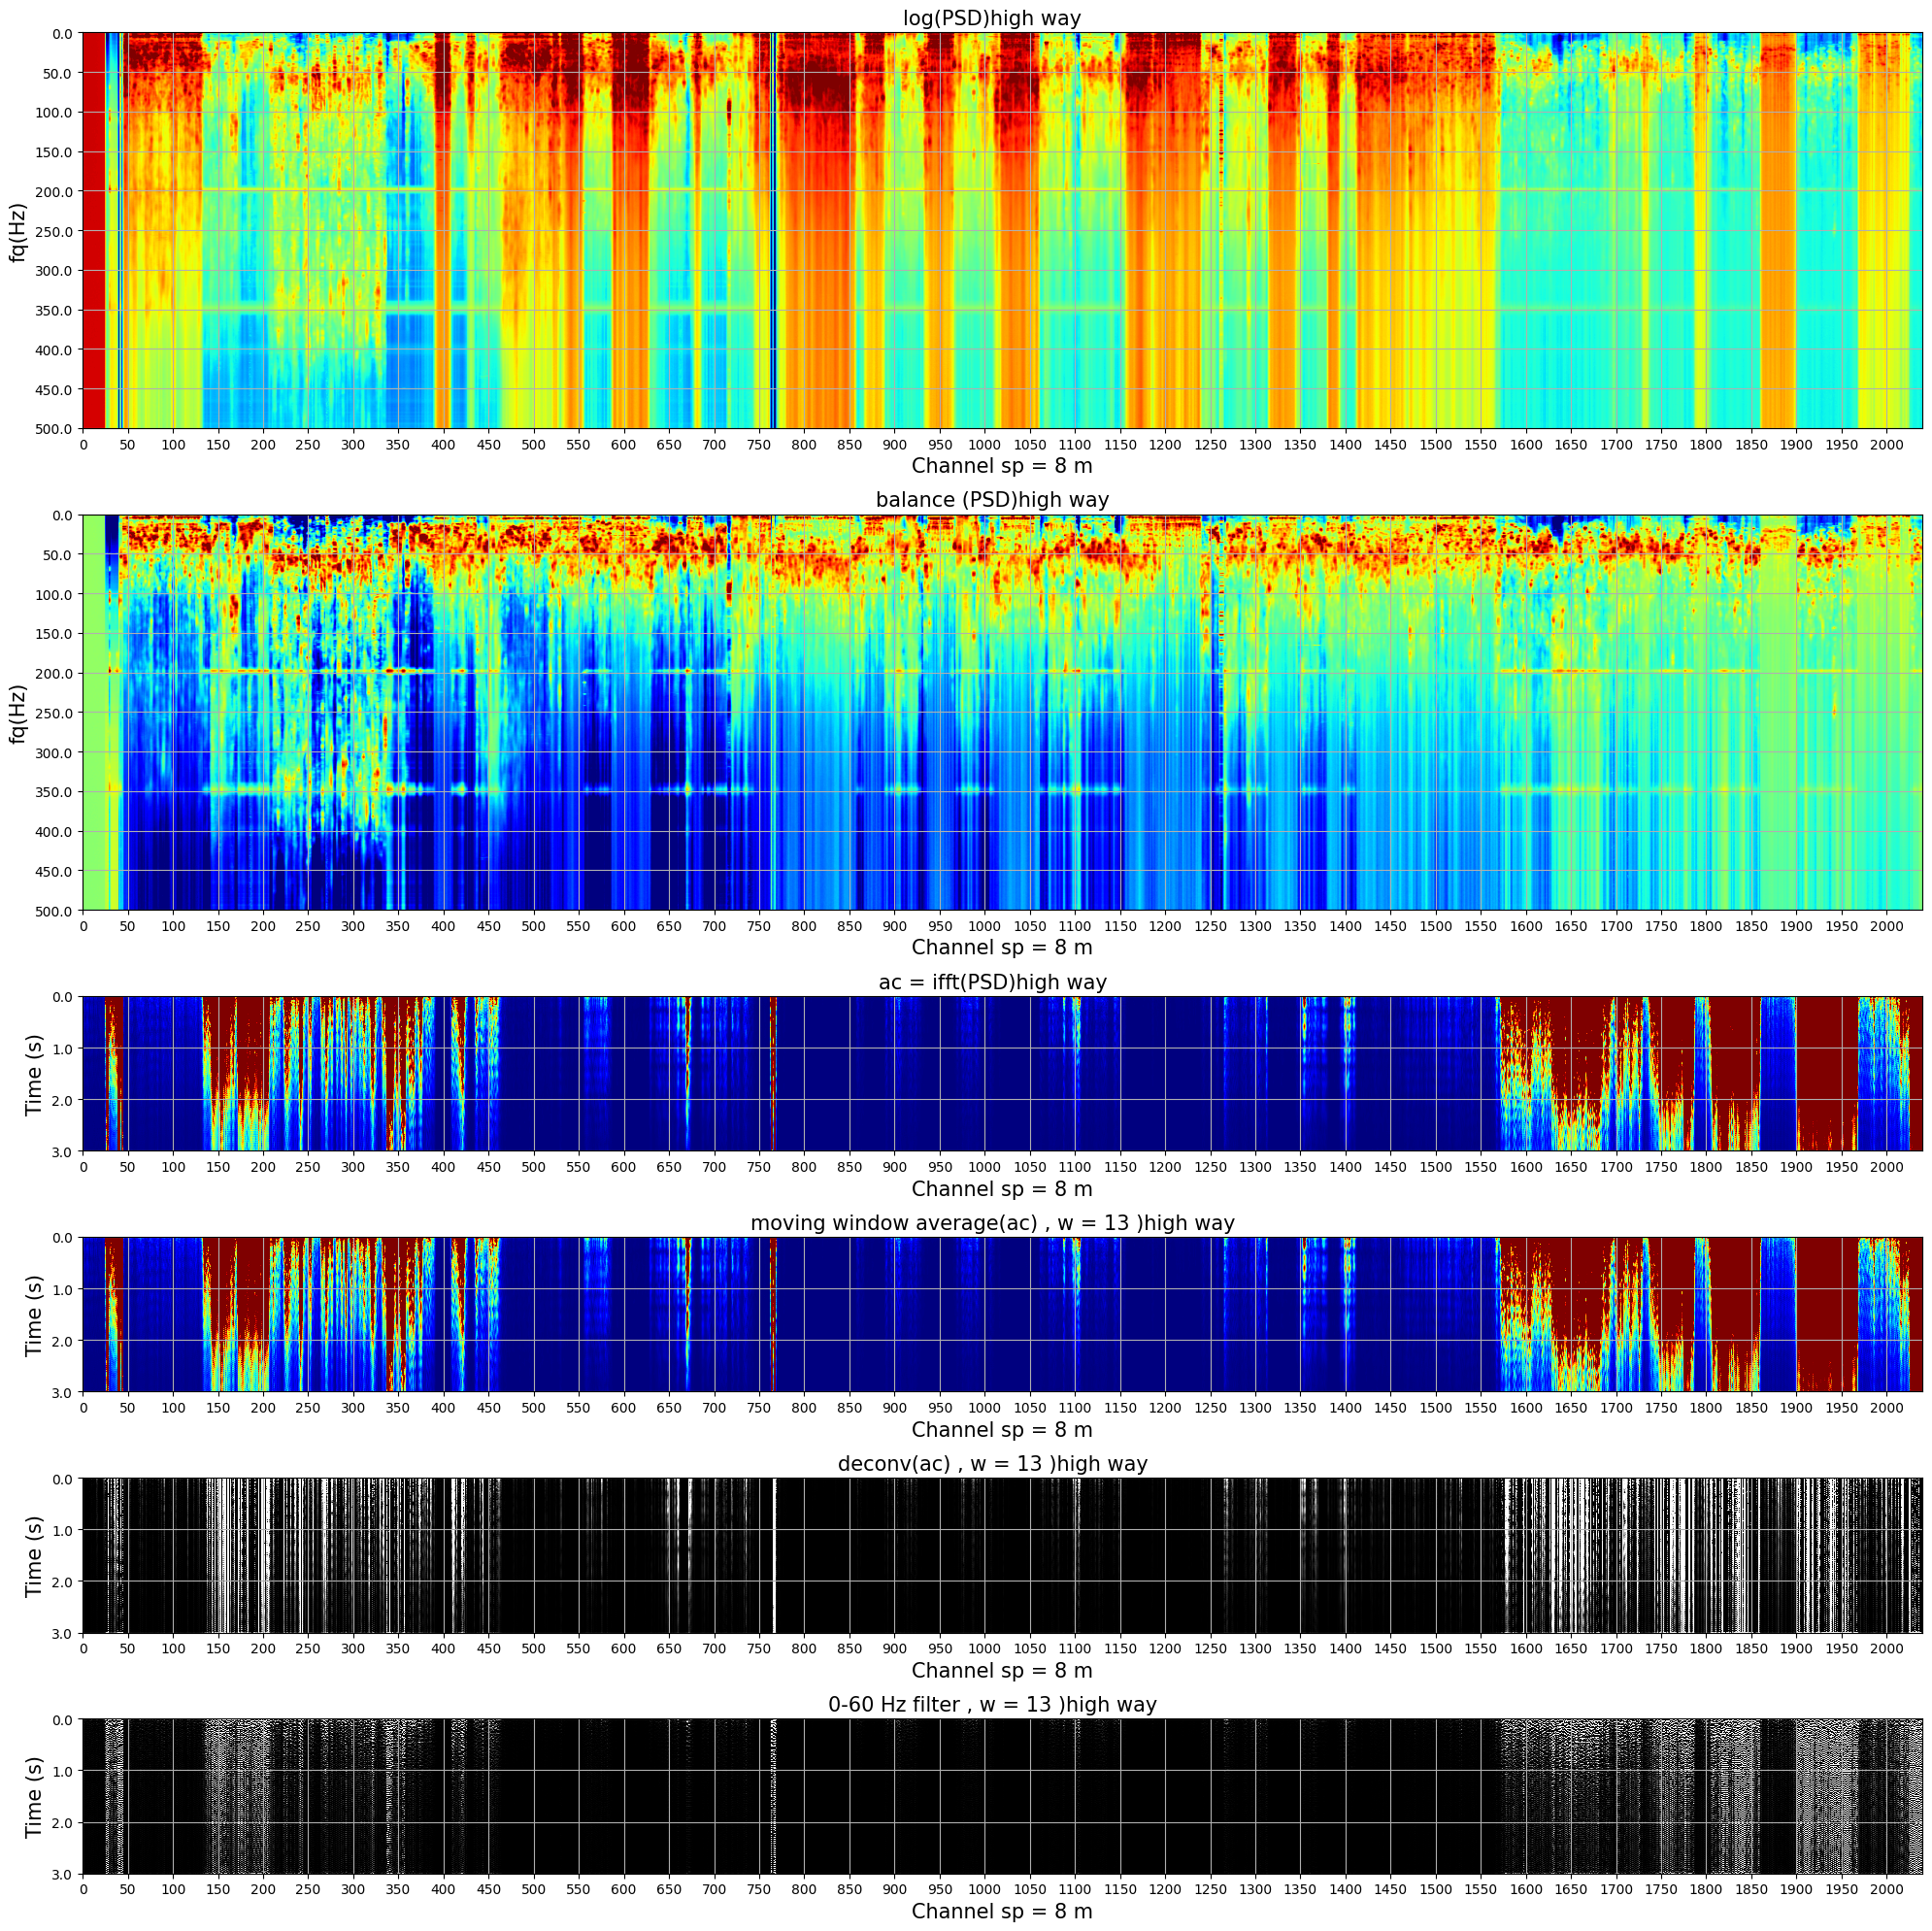

In [89]:

import scipy
from DasTools import DasPrep as dp

def plot_sub_set(ax  , xsticks = [] , ysticks = []  , xlabel = '', ylabel = '', title = ''):
    fonts = 15
    ax.set_yticks(ysticks[0],ysticks[1])
    ax.set_xticks(xsticks[0],xsticks[1])
    ax.set_ylabel(ylabel,fontsize=fonts)
    ax.set_xlabel(xlabel,fontsize=fonts)
    ax.grid()
    ax.set_title(title,fontsize=fonts)
    ax.tick_params(axis='x', labelsize=fonts-5)
    ax.tick_params(axis='y', labelsize=fonts-5)



def show_ifft_time_range_amtitude_channel(flist  , ch_list, frequencise ,  dis_spacing ,  title ,  save_path  , t_range = [0,-1] , start_time = None , end_time = None ,psdfile = None  ):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    all_AC = []
    all_psd = []
    if psdfile is None:
        for ch in ch_list:
            for fi in flist:
                with h5py.File(fi, 'r') as f:
                    if len(f[str(ch)].keys()) == 1 :
                        dset = f[str(ch)]['01']
                    else:
                        dset = f[str(ch)]
                    time = [i for i in dset.keys()][t_range[0] : t_range[-1]]
                    
                    if start_time is not None and end_time is not None : 
                        time = time[time.index(start_time):time.index(end_time)+1]
                    psd = np.average([dset[ti] for ti in time] ,axis=0)
                    all_psd.append(psd)
                    AC = np.fft.ifft( np.abs(np.append(psd[::-1][:-2] , psd)))
                    f.close()
                    # AC = np.fft.fftshift(AC)
                    all_AC.append(np.abs(AC[: len(AC)//2]))


        with h5py.File(save_path+'acf' +'.hdf5', 'w') as f:
            f.create_dataset(str(time),  data=all_AC )
            f.close()
    else:
        with h5py.File(psdfile, 'r') as f:
            all_psd = np.array(f['psd'][ch_list[0] : ch_list[1], :])
            print(all_psd.shape)
            all_AC = np.abs(np.fft.ifft2(np.append(all_psd[::-1 , ] , all_psd ,axis= 1))[: , : len(all_psd[0])])
            time = ""
            print(all_AC.shape)

    sum_psd = np.sum(all_psd,axis = 1)    
    balenced_psd =  np.divide(all_psd.T,sum_psd /70000)
    print(balenced_psd.std() ,all_psd.std()) 
    all_AC = np.divide(all_AC.T , sum_psd /70000 ).T
    w = 13
    rolling_mean = np.array ([ np.convolve(ac, np.ones(w), "valid") / w for ac in all_AC] )
    deco = np.array([scipy.signal.deconvolve(all_AC[i] , rolling_mean[i])[1] for i in range(len(all_AC))])
    filter_data = dp.bandpass(deco, 0.001, 10 , 60 )
    # filter_data = dp.lowpass(deco, 0.001, 60 )




    plt.figure(figsize=(20, 20 ))
    fq_stick = [ np.linspace(0,len(all_psd[0]),11) ,np.linspace(0,frequencise//2,11) ]
    time_stick = [np.linspace(0,len(all_AC[0]) , 4) ,np.around( np.linspace(0, len(all_AC[0])/frequencise , 4 ) , 1) ]
    ch_stick = [range(0,len(all_psd),50) , range(ch_list[0], ch_list[1],50)]
    ax_list = []
    ax_list.append(plt.subplot2grid((8, 1), (0, 0), rowspan=2))
    ax_list.append(plt.subplot2grid((8, 1), (2, 0), rowspan=2))
    ax_list.append(plt.subplot2grid((8, 1), (4, 0), rowspan=1))
    ax_list.append(plt.subplot2grid((8, 1), (5, 0), rowspan=1))  
    ax_list.append(plt.subplot2grid((8, 1), (6, 0), rowspan=1))
    ax_list.append(plt.subplot2grid((8, 1), (7, 0), rowspan=1))


    ax_list[0].imshow(np.log(all_psd).T, aspect='auto', cmap='jet', vmin=0, vmax=12)
    plot_sub_set(ax_list[0] , ch_stick , fq_stick , 'Channel sp = 8 m' , 'fq(Hz)' , "log(PSD)"+title + time)
    
    ax_list[1].imshow(np.log(balenced_psd), aspect='auto', cmap='jet', vmin=0, vmax=6)
    plot_sub_set(ax_list[1] , ch_stick , fq_stick , 'Channel sp = 8 m' , 'fq(Hz)' , "balance (PSD)"+title + time)


    all_AC_s= all_AC /np.max(all_AC) * 20
    ax_list[2].imshow(all_AC_s.T, aspect='auto', cmap='jet', vmin=0, vmax= all_AC_s.std() /20)
    plot_sub_set(ax_list[2] , ch_stick , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "ac = ifft(PSD)"+title + time)

    rolling_mean_s = rolling_mean / np.max(rolling_mean) * 20
    ax_list[3].imshow(rolling_mean_s.T, aspect='auto', cmap='jet', vmin=0, vmax=rolling_mean_s.std() /20)
    plot_sub_set(ax_list[3] , ch_stick , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "moving window average(ac) , w = "+str(w)+" )"+title + time)

    deco_s = deco/np.max(deco) * 30
    ax_list[4].imshow(deco_s.T, aspect='auto', cmap='gray', vmin=0, vmax=deco_s.std() /30)
    plot_sub_set(ax_list[4] , ch_stick , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "deconv(ac) , w = "+str(w)+" )"+title + time)

    filter_data_s = filter_data/np.max(filter_data) * 20
    ax_list[5].imshow(filter_data_s.T, aspect='auto', cmap='gray', vmin=0, vmax=filter_data_s.std()/20)
    plot_sub_set(ax_list[5] , ch_stick , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "0-60 Hz filter , w = "+str(w)+" )"+title + time)
    plt.tight_layout() 
    plt.savefig(save_path+time+" 10-60 filter,ch "+str(ch_list))
    plt.show()
    plt.close()

show_ifft_time_range_amtitude_channel(flist=[h5fname] , ch_list = [0,2040] , frequencise= 1000 , dis_spacing= 8 , title='high way   ' , save_path='/mnt/f/Highway_2024_0510/output/psd_5_11_v3/')

